## 1.提取DBC文件信息转为数据域分割的GroundTruth

In [1]:
import re
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
node = []
allDatas = []
siganlList = []
SignalsName = []
messageName = []

In [2]:
def readFile(file_name):
    global node,allDatas,siganlList,SignalsName,messageName
    ''' 得到dbc文件的绝对路径'''
    filePath = file_name
    if filePath:
        print(filePath)
        f = open(filePath, "r")  # 设置文件对象
    else:
        print("读取文件失败！")
        return 0
    """
    NodesPattern:节点
    MessagePattern：消息
    SignalPattern：信号
    """
    NodesPattern = re.compile(r"BU_: (.*)", re.S)
    MessagePattern = re.compile(r"BO_ (.*?) (.*?): (.*?) (.*)", re.S)
#     SignalPattern = re.compile('''SG_ (.*?) : (.*?)\|(.*?)@.*? \((.*?),(.*?)\) \[(.*?)\|(.*?)\] "(.*?)" (.*)''', re.S)
    SignalPattern = re.compile('''SG_ (.*?) : (.*?)\|(.*?)@([0-9])([+|-]) \((.*?),(.*?)\) \[(.*?)\|(.*?)\] "(.*?)" (.*)''', re.S)
    DefaultValue = '''BA_ "GenSig(.*?)" SG_ (\d+) signalname (\d+);'''

    line = f.readline()
    allDatas=[]
    while line:
        """ 匹配出节点 """
        NodesSearched = re.search(NodesPattern, line.strip())
        if NodesSearched:
            node = NodesSearched.group(1).split(" ")
            #print(node)
        """ 匹配出消息 """
        MessageSearched = re.search(MessagePattern, line.strip())
        if MessageSearched:
            siganlList.clear()
            """如果匹配到了message，则获取到message的相关参数 
             比如匹配到了NM_Message_ESC_409，则会解析出改message的一些参数构成list对象['1033', 'NM_Message_ESC_409', '8', 'ESC']
             这四个参数分别是 messgage ID ;message name ; messgae dataLenth ,message sender
             而且把这个list对象 加在了 siganlList 索引0的位置
            """
            Message = list(MessageSearched.groups())
            siganlList.append(Message)
            """ 只 要 message的名字 messageName 列表中"""
            messageName.append(Message[1])
            """读取下一行"""
            line = f.readline()
            """因为有些message并没有定义signal，所以 下一行还是message"""
            MessageSearched = re.search(MessagePattern, line.strip())
            SignalSearched = re.search(SignalPattern, line.strip())
            """下一行如果不是message的内容 就一定是signal的内容了"""
            if not MessageSearched:
                while SignalSearched:
                    """获取信号的参数追加到siganlList"""
                    signal = list(SignalSearched.groups())
                    siganlList.append(signal)
                    """只获取 signal name"""
                    SignalsName.append(signal[0])

                    # 再次解析信号，直到这个message下的信号全部解析完毕
                    line = f.readline()
                    SignalSearched = re.search(SignalPattern, line.strip())
           # print(siganlList)
            c = copy.deepcopy(siganlList)
            allDatas.append(c)
        else:
            line = f.readline()
            MessageSearched = re.search(MessagePattern, line.strip())
    f.close()  # 将文件关闭
    return 1

In [3]:
import os
file_names = []
path = os.path.abspath('../My_DBC')
# path = os.path.abspath('../opendbc-master/opendbc-master-delFalseData')
# path = os.path.abspath('./opendbc-master/opendbc-master')
dirs = os.listdir(path)                    # 获取指定路径下的文件
for i in dirs:
    if os.path.splitext(i)[1] == ".dbc":
        file_names.append(os.path.join(path,i))
file_names

['D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\cadillac_ct6_object.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\cadillac_ct6_powertrain.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\gm_global_a_powertrain.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_hatchback_ex_2017_can_generated.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_sedan_16_diesel_2019_can_generated.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_touring_2016_can_generated.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\tesla_can.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\tesla_powertrain.dbc',
 'D:\\--storage-

## 2.处理原始bit数据和GroundTruth数据的函数

In [4]:
def get_id_labels(index):
    file_name = file_names[index]
    readFile(file_name)

    # 将DBC文件中的ID(10进制数)改为ID(16进制数)
    data_gts = {}
    for alldata in allDatas:
        data_gts[str(hex(int(alldata[0][0])))[2:]] = alldata

    # 得到DBC文件中各ID Message对应信号位置
    all_id_lsbs = {}
    for k in data_gts.keys():
        message = data_gts[k]
        lsb_list = []
        series = np.zeros(64)
        message_id = message[0][0]+"_"+message[0][1]
        del message[0]
        for signal in message:
            start = int(signal[1])
            length = int(signal[2])
            endianness = int(signal[3])
            start_row = int(start / 8)
            start_col = 8 - (start - start_row * 8) - 1
            new_start = start_row * 8 + start_col
            if endianness == 0:
                new_end = new_start + length
                cur_lsb = new_end - 1
            if endianness == 1:
                cur_lsb = new_start
            lsb_list.append(cur_lsb)
        all_id_lsbs[k] = lsb_list

    # 将各ID Message的信号位置改为 0/1 label
    all_id_labels = {}
    for k in all_id_lsbs:
        cur_lsb_list = all_id_lsbs[k]
        cur_label = np.zeros(64)
        for cur_lsb in cur_lsb_list:
            cur_label[cur_lsb] = 1
        all_id_labels[k] = cur_label
    return all_id_lsbs, all_id_labels

In [5]:
def get_ids(id_tracedict_int, all_id_labels):
    ids = []
    for id in id_tracedict_int.keys():
        if(id_tracedict_int.__contains__(id) and all_id_labels.__contains__(id)):
            ids.append(id)
    return ids

In [6]:
def get_trace(data):
    group = data.groupby(by="ID")
    id_tracedict = {}
    for trace in list(group):
        id_tracedict[trace[0]] = trace[1]["bin"].apply(lambda x: list(x)).apply(lambda x: list(map(int, x))).tolist()
    return id_tracedict

In [7]:
import random
# 设置全局的随机种子
random.seed(100)

In [8]:
def get_trace_data_dict(cur_ids, id_tracedict_int, all_id_labels, trace_data_dict, trace_label_dict): 
    for id in cur_ids:
        trace_data_dict[id] = id_tracedict_int[id]
        trace_label_dict[id] = all_id_labels[id]

## 3.综合Honda和Cadillac数据，得到训练集和测试集（包括0/1Label）

#### 得到label

In [9]:
# 合并所有Honda车的Ground Truth的 0/1 label
all_id_lsbs3, dict3 = get_id_labels(3)
all_id_lsbs4, dict4 = get_id_labels(4)
all_id_lsbs5, dict5 = get_id_labels(5)
honda_id_labels = dict()
for key in dict3.keys() | dict4.keys() | dict5.keys():
    for d in (dict3, dict4, dict5):
        if d.__contains__(key):
            honda_id_labels[key] = d[key]
            break
honda_id_lsb = dict()
for key in all_id_lsbs3.keys() | all_id_lsbs4.keys() | all_id_lsbs5.keys():
    for d in (all_id_lsbs3, all_id_lsbs4, all_id_lsbs5):
        if d.__contains__(key):
            honda_id_lsb[key] = d[key]
            break

D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\honda_civic_hatchback_ex_2017_can_generated.dbc
D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\honda_civic_sedan_16_diesel_2019_can_generated.dbc
D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\honda_civic_touring_2016_can_generated.dbc


In [10]:
# 合并所有Cadillac以及Chevy车的Ground Truth的 0/1 label
all_id_lsbs0, dict0 = get_id_labels(0)
all_id_lsbs1, dict1 = get_id_labels(1)
all_id_lsbs2, dict2 = get_id_labels(2)
cadillac_id_labels = dict()
for key in dict0.keys() | dict1.keys() | dict2.keys():
    for d in (dict0, dict1, dict2):
        if d.__contains__(key):
            cadillac_id_labels[key] = d[key]
            break
cadillac_id_lsb = dict()
for key in all_id_lsbs0.keys() | all_id_lsbs1.keys() | all_id_lsbs2.keys():
    for d in (all_id_lsbs0, all_id_lsbs1, all_id_lsbs2):
        if d.__contains__(key):
            cadillac_id_lsb[key] = d[key]
            break

D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\cadillac_ct6_object.dbc
D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\cadillac_ct6_powertrain.dbc
D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\gm_global_a_powertrain.dbc


In [11]:
# 合并所有Cadillac以及Chevy车的Ground Truth的 0/1 label
all_id_lsbs0, dict0 = get_id_labels(0)
all_id_lsbs1, dict1 = get_id_labels(1)
all_id_lsbs2, dict2 = get_id_labels(2)
chevy_id_labels = dict()
for key in dict0.keys() | dict1.keys() | dict2.keys():
    for d in (dict0, dict1, dict2):
        if d.__contains__(key):
            chevy_id_labels[key] = d[key]
            break
chevy_id_lsb = dict()
for key in all_id_lsbs0.keys() | all_id_lsbs1.keys() | all_id_lsbs2.keys():
    for d in (all_id_lsbs0, all_id_lsbs1, all_id_lsbs2):
        if d.__contains__(key):
            chevy_id_lsb[key] = d[key]
            break

D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\cadillac_ct6_object.dbc
D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\cadillac_ct6_powertrain.dbc
D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\gm_global_a_powertrain.dbc


In [12]:
def plt_data_flip_dict(train_data_dict, train_label_dict):
    for id in train_data_dict.keys():
        messagelist = train_data_dict[id]
        trace_len = len(messagelist)
        bit_flip = np.zeros(64)
        previous = messagelist[0]
        for item in messagelist:
            for ix in range(64):
                if item[ix] != previous[ix]:
                    bit_flip[ix] = bit_flip[ix] + 1
            previous = item
        for ix in range(64):
            bit_flip[ix] = bit_flip[ix] / trace_len
    #     print("--------------------------------------------------------------------------------------------------------")
    #     print(id+": ")
        fig = plt.figure(figsize=(8,3))
        plt.bar(np.arange(64),bit_flip)
        plt.bar(np.arange(64),train_label_dict[id])

In [13]:
def clear_data_label_dict(true_train_ids, train_data_dict,train_label_dict):
    new_train_data_dict = {}
    new_train_label_dict = {}
    for i in range(len(train_data_dict)):
        if i in true_train_ids:
            id = list(train_data_dict.keys())[i]
            new_train_data_dict[id] = train_data_dict[id]
            new_train_label_dict[id] = train_label_dict[id]
    return new_train_data_dict, new_train_label_dict

In [14]:
def get_true_ids(true_train_ids, train_data_dict):
    true_ids = []
    for i in range(len(train_data_dict)):
        if i in true_train_ids:
            id = list(train_data_dict.keys())[i]
            true_ids.append(id)
    return true_ids

In [15]:
def get_trace_data(id_tracedict_int, all_id_labels): 
    cur_trace_data = []
    cur_trace_label = []
    for id in id_tracedict_int.keys():
        cur_trace = id_tracedict_int[id]
        cur_label = all_id_labels[id]
        length = len(cur_trace)
        start = 4000
        end = start + 1000
        n = int((length-4000)/1000)
        for i in range(n):
            cur_trace_data.append(cur_trace[start: end])
            cur_trace_label.append(cur_label)
            start = end
            end = start + 1000
    return cur_trace_data, cur_trace_label

#### honda数据集

In [16]:
# 得到Honda车的子数据集数据
data_hd = pd.read_csv('../Data/Honda_process_bin/honda001.csv')

In [17]:
data_hd.shape

(1509141, 5)

In [18]:
len(list(data_hd.groupby(['ID'])))

47

In [19]:
((data_hd.groupby(['ID']).count()/1000).astype('int')).sum()

Unnamed: 0    1492
Timestamp     1492
Data          1492
bin           1492
dtype: int64

In [20]:
# 得到Honda车子的数据集的大Trace dict
id_tracedict_hd = get_trace(data_hd)
honda_ids = get_ids(id_tracedict_hd, honda_id_labels)
honda_data_dict = {}
honda_label_dict = {}
get_trace_data_dict(honda_ids, id_tracedict_hd, honda_id_labels, honda_data_dict, honda_label_dict)

In [21]:
len(honda_ids)

16

In [22]:
true_honda_ids = [1,6,7,10,12, 13]

In [23]:
true_honda_idname = get_true_ids(true_honda_ids, honda_data_dict)
true_honda_idname

['158', '1d0', '1ea', '255', '309', '324']

In [24]:
arr = pd.DataFrame(['158', '1d0', '1ea', '255', '309', '324'],columns=["wo"])
arr['wo'].apply(lambda x: int(x, 16))
# arr
#   (6 0+)  (5 0+)   (2 0- 2 0+)  (9 0+) (7 0+) (7 0+) (3 0+)
# ()

0    344
1    464
2    490
3    597
4    777
5    804
Name: wo, dtype: int64

In [25]:
new_honda_data_dict, new_honda_label_dict = clear_data_label_dict(true_honda_ids, honda_data_dict, honda_label_dict)

In [26]:
honda_trace_data, honda_trace_label = get_trace_data(new_honda_data_dict, new_honda_label_dict)

#### cadillac数据集

In [27]:
# 得到Cadillac车的子数据集数据
data_cd = pd.read_csv('../Data/Cadillac_process_bin/001.txt.csv')

In [28]:
data_cd.shape

(1521400, 5)

In [29]:
len(list(data_cd.groupby(['ID'])))

152

In [30]:
((data_cd.groupby(['ID']).count()/1000).astype('int')).sum()

Unnamed: 0    1473
Timestamp     1473
Data          1473
bin           1473
dtype: int64

In [31]:
# 得到Honda车子的数据集的大Trace dict
id_tracedict_cd = get_trace(data_cd)
cadillac_ids = get_ids(id_tracedict_cd, cadillac_id_labels)
cadillac_data_dict = {}
cadillac_label_dict = {}
get_trace_data_dict(cadillac_ids, id_tracedict_cd, cadillac_id_labels, cadillac_data_dict, cadillac_label_dict)

In [32]:
len(cadillac_ids)

50

In [33]:
true_cadillac_ids = [8,9,10,11,15,19,21,26,27]

In [34]:
true_cadillac_idname = get_true_ids(true_cadillac_ids, cadillac_data_dict)
true_cadillac_idname

['17d', '180', '184', '1a1', '1e5', '260', '262', '348', '34a']

In [35]:
arr = pd.DataFrame(['17d', '180', '184', '1a1', '1e5', '260', '262', '348', '34a'],columns=["wo"])
arr['wo'].apply(lambda x: int(x, 16))

0    381
1    384
2    388
3    417
4    485
5    608
6    610
7    840
8    842
Name: wo, dtype: int64

In [36]:
new_cadillac_data_dict, new_cadillac_label_dict = clear_data_label_dict(true_cadillac_ids, cadillac_data_dict, cadillac_label_dict)

In [37]:
cadillac_trace_data, cadillac_trace_label = get_trace_data(new_cadillac_data_dict, new_cadillac_label_dict)

#### chevy数据集

In [38]:
# 得到Chevy车的子数据集数据
data_ch = pd.read_csv('../Data/Chevy_process_bin/chevy001.csv')

In [39]:
data_ch.shape

(1512802, 5)

In [40]:
len(list(data_ch.groupby(['ID'])))

85

In [41]:
((data_ch.groupby(['ID']).count()/1000).astype('int')).sum()

Unnamed: 0    1479
Timestamp     1479
Data          1479
bin           1479
dtype: int64

In [42]:
id_tracedict_ch = get_trace(data_ch)
chevy_ids = get_ids(id_tracedict_ch, chevy_id_labels)

In [43]:
len(chevy_ids)

32

In [44]:
chevy_data_dict = {}
chevy_label_dict = {}
get_trace_data_dict(chevy_ids, id_tracedict_ch, chevy_id_labels, chevy_data_dict, chevy_label_dict)

In [45]:
true_chevy_ids = [6,7,13,14,15,28]

In [46]:
true_chevy_idname = get_true_ids(true_chevy_ids, chevy_data_dict)
true_chevy_idname

['17d', '1a1', '32a', '348', '34a', 'be']

In [47]:
arr = pd.DataFrame(['17d', '1a1', '32a', '348', '34a', 'be'],columns=["wo"])
arr['wo'].apply(lambda x: int(x, 16))

0    381
1    417
2    810
3    840
4    842
5    190
Name: wo, dtype: int64

In [48]:
new_checy_data_dict, new_chevy_label_dict = clear_data_label_dict(true_chevy_ids, chevy_data_dict, chevy_label_dict)

In [49]:
chevy_trace_data, chevy_trace_label = get_trace_data(new_checy_data_dict, new_chevy_label_dict)

#### 得到训练集和测试集

In [50]:
def get_data_label(id_tracedict_int, all_id_labels):
    cur_trace_data, cur_trace_label = get_trace_data(id_tracedict_int, all_id_labels)
    trace_indexs = pd.DataFrame(cur_trace_label).index.tolist()
    random.shuffle(trace_indexs)
    trace_data, trace_labels = np.array(cur_trace_data)[trace_indexs], np.array(cur_trace_label)[trace_indexs]
    return trace_data, trace_labels

In [51]:
def shuffle_data_label(cur_trace_data, cur_trace_label):
    trace_indexs = pd.DataFrame(cur_trace_label).index.tolist()
    random.shuffle(trace_indexs)
    trace_data, trace_labels = np.array(cur_trace_data)[trace_indexs], np.array(cur_trace_label)[trace_indexs]
    return trace_data, trace_labels

In [52]:
train_data = np.concatenate([honda_trace_data,cadillac_trace_data])
train_labels = np.concatenate([honda_trace_label,cadillac_trace_label])
train_data, train_labels = shuffle_data_label(train_data, train_labels)

In [53]:
test_data, test_labels = shuffle_data_label(chevy_trace_data, chevy_trace_label)

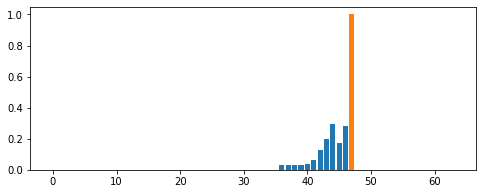

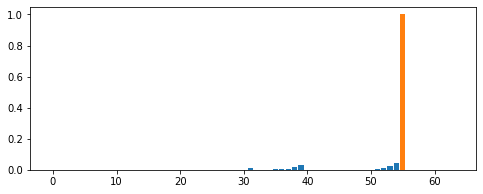

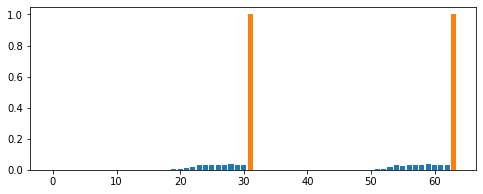

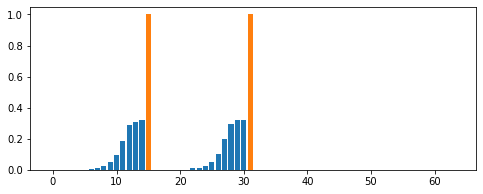

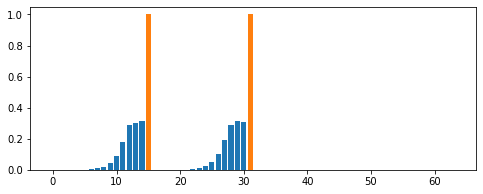

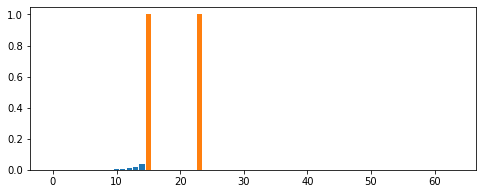

In [269]:
plt_data_flip_dict(new_checy_data_dict, new_chevy_label_dict)

In [55]:
test_message_0 = {}
test_message_label_0 = {}
test_message_0['17d'] = new_checy_data_dict['17d']
test_message_label_0['17d'] = new_chevy_label_dict['17d']
testdata0,testlabel0 = get_trace_data(test_message_0, test_message_label_0)

In [56]:
test_message_1 = {}
test_message_label_1 = {}
test_message_1['1a1'] = new_checy_data_dict['1a1']
test_message_label_1['1a1'] = new_chevy_label_dict['1a1']
testdata1,testlabel1 = get_trace_data(test_message_1, test_message_label_1)

In [57]:
test_message_2 = {}
test_message_label_2 = {}
test_message_2['32a'] = new_checy_data_dict['32a']
test_message_label_2['32a'] = new_chevy_label_dict['32a']
testdata2,testlabel2 = get_trace_data(test_message_2, test_message_label_2)

In [82]:
test_message_3 = {}
test_message_label_3 = {}
test_message_3['348'] = new_checy_data_dict['348']
test_message_label_3['348'] = new_chevy_label_dict['348']
testdata3,testlabel3 = get_trace_data(test_message_3, test_message_label_3)

In [59]:
test_message_4 = {}
test_message_label_4 = {}
test_message_4['be'] = new_checy_data_dict['be']
test_message_label_4['be'] = new_chevy_label_dict['be']
testdata4,testlabel4 = get_trace_data(test_message_4, test_message_label_4)

In [326]:
# '1a1', '32a', '348', 'be'
# 417, 810, 840, 190

In [357]:
# np.array(mytest_data1).shape,np.array(mytest_labels1).shape

In [100]:
model = load_model('multihead model_((1+2)+input1)+(3+input2).h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [137]:
def get_bit_flip(trace_data):
    messagelist = trace_data
    trace_len = len(messagelist)
    bit_flip = np.zeros(64)
    previous = messagelist[0]
    for item in messagelist:
        for ix in range(64):
            if item[ix] != previous[ix]:
                bit_flip[ix] = bit_flip[ix] + 1
        previous = item
    for ix in range(64):
        bit_flip[ix] = bit_flip[ix] / trace_len
    return bit_flip

In [138]:
# model = load_model('multihead model_((1+2)+input1)+(3+input2).h5')
# multihead model_((1+2)+input1)+(3+input2).h5
# best_model = load_model(model_name+'.h5')
def test(testdata, testlabel):
    matrix_test_data1, matrix_test_labels1 = trace2matrixTrace(testdata, testlabel)
    test_data_4_11 = np.expand_dims(matrix_test_data1, 3)
    test_data_4_21 = np.expand_dims(testdata, 3)
    mytest_data1 = [test_data_4_11, test_data_4_21]
    mytest_labels1 = np.array(testlabel)
    print("测试集:")
    predict_target_test_msb_prob1 = model.predict(mytest_data1)
    predict_target_test_msb_label1 = (predict_target_test_msb_prob1 > 0.5).astype(int)
    predict_target_test_msb_1D1 = predict_target_test_msb_label1.flatten()
    test_labels_1D1 = mytest_labels1.flatten()
    print("预测正确数量,训练集样本量:")
    print(sum(predict_target_test_msb_1D1 == test_labels_1D1),len(test_labels_1D1))
    print("测试集精确度等指标：")
    print(metrics.classification_report(test_labels_1D1,predict_target_test_msb_1D1))
    print("混淆矩阵：")
    print(metrics.confusion_matrix(test_labels_1D1,predict_target_test_msb_1D1))
    index = 0
    plt.plot(predict_target_test_msb_label1[index],color='blue',label='pred')
    plt.bar(np.arange(64),mytest_labels1[index],color='black',label='label')
    plt.bar(np.arange(64),get_bit_flip(test_data_4_21[0]),color='red',label='bitFlip')
    plt.legend()
    print(predict_target_test_msb_label1)
    print(get_bit_flip(test_data_4_21[0]).tolist())
    return predict_target_test_msb_label1,mytest_labels1,get_bit_flip(test_data_4_21[0])

In [97]:
type(testdata1)

list

测试集:
预测正确数量,训练集样本量:
1344 1344
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1323
         1.0       1.00      1.00      1.00        21

    accuracy                           1.00      1344
   macro avg       1.00      1.00      1.00      1344
weighted avg       1.00      1.00      1.00      1344

混淆矩阵：
[[1323    0]
 [   0   21]]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


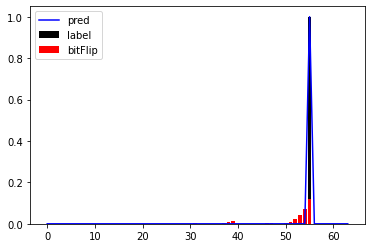

In [100]:
pred1,label1 = test(testdata1, testlabel1)

测试集:
预测正确数量,训练集样本量:
119 128
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96       124
         1.0       0.27      0.75      0.40         4

    accuracy                           0.93       128
   macro avg       0.63      0.84      0.68       128
weighted avg       0.97      0.93      0.95       128

混淆矩阵：
[[116   8]
 [  1   3]]


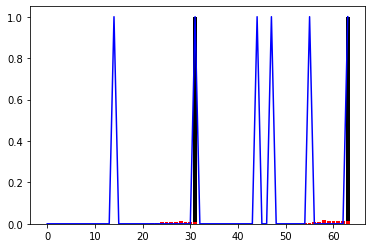

In [88]:
pred2,label2 = test(testdata2, testlabel2)

测试集:
预测正确数量,训练集样本量:
512 512
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       496
         1.0       1.00      1.00      1.00        16

    accuracy                           1.00       512
   macro avg       1.00      1.00      1.00       512
weighted avg       1.00      1.00      1.00       512

混淆矩阵：
[[496   0]
 [  0  16]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0

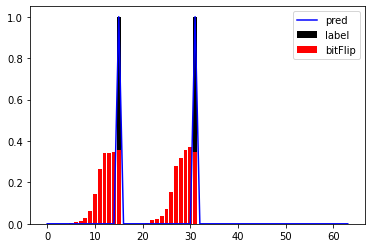

In [83]:
pred1,label3, bitflip = test(testdata3, testlabel3)

In [72]:
pred1[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [79]:
bitflip

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.002, 0.009, 0.015, 0.029,
       0.063, 0.145, 0.264, 0.341, 0.341, 0.347, 0.357, 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.002, 0.019, 0.025, 0.039, 0.073, 0.155,
       0.277, 0.318, 0.354, 0.371, 0.345, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   ])

In [81]:
bitflip_matrix = []
for i in range(8):
    for j in range(8):
        bitflip_matrix.append([7-i,j,bitflip[i*8+j]])
bitflip_matrix

[[7, 0, 0],
 [7, 1, 0],
 [7, 2, 0],
 [7, 3, 0],
 [7, 4, 0],
 [7, 5, 0],
 [7, 6, 0],
 [7, 7, 0],
 [6, 0, 0],
 [6, 1, 0],
 [6, 2, 0],
 [6, 3, 0],
 [6, 4, 0],
 [6, 5, 0],
 [6, 6, 0],
 [6, 7, 0],
 [5, 0, 0],
 [5, 1, 0],
 [5, 2, 0],
 [5, 3, 0],
 [5, 4, 0],
 [5, 5, 0],
 [5, 6, 0],
 [5, 7, 0],
 [4, 0, 0],
 [4, 1, 0],
 [4, 2, 0],
 [4, 3, 0],
 [4, 4, 0],
 [4, 5, 0],
 [4, 6, 0],
 [4, 7, 0],
 [3, 0, 0],
 [3, 1, 0],
 [3, 2, 0],
 [3, 3, 0],
 [3, 4, 0],
 [3, 5, 0],
 [3, 6, 0],
 [3, 7, 0],
 [2, 0, 0],
 [2, 1, 0],
 [2, 2, 0],
 [2, 3, 0],
 [2, 4, 0],
 [2, 5, 0],
 [2, 6, 0],
 [2, 7, 0],
 [1, 0, 0],
 [1, 1, 0],
 [1, 2, 0],
 [1, 3, 0],
 [1, 4, 0],
 [1, 5, 0],
 [1, 6, 0],
 [1, 7, 0],
 [0, 0, 0],
 [0, 1, 0],
 [0, 2, 0],
 [0, 3, 0],
 [0, 4, 0],
 [0, 5, 0],
 [0, 6, 0],
 [0, 7, 0]]

测试集:
预测正确数量,训练集样本量:
2845 2944
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      2852
         1.0       0.46      0.50      0.48        92

    accuracy                           0.97      2944
   macro avg       0.72      0.74      0.73      2944
weighted avg       0.97      0.97      0.97      2944

混淆矩阵：
[[2799   53]
 [  46   46]]


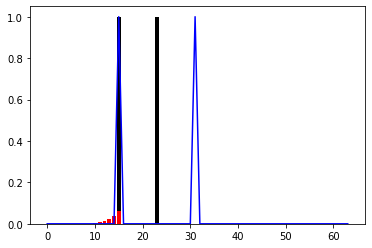

In [90]:
pred1,label4 = test(testdata4, testlabel4)

## DL Model

In [54]:
def vetor2matrix(cur_message):
    cur_matrix = [[0] * 8 for _ in range(8)]
    index = 0
    for row in range(8):
        for col in range(8):
            cur_matrix[row][col] = cur_message[index] 
            index = index + 1
    return cur_matrix

def trace2matrixTrace(trace_data, trace_label):
    matrix_data = []
    matrix_label = []
    for i in range(len(trace_data)):
        cur_trace_data = trace_data[i]
        cur_matrix_data = []
        for message in cur_trace_data:
            cur_matrix = vetor2matrix(message)
            cur_matrix_data.append(cur_matrix)
        matrix_data.append(np.concatenate(cur_matrix_data))
        matrix_label.append(vetor2matrix(trace_label[i]))
    return np.array(matrix_data), np.array(matrix_label)

In [55]:
matrix_train_data, matrix_train_labels = trace2matrixTrace(train_data, train_labels)

In [56]:
matrix_test_data, matrix_test_labels = trace2matrixTrace(test_data, test_labels)

In [57]:
import keras
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, Input, Permute, BatchNormalization, Flatten, MaxPooling1D, Conv1D,Conv2D, MaxPooling2D
from keras.layers import concatenate, add, Reshape
from keras.losses import mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import mean_squared_error
import keras.backend as K
from sklearn import metrics
from keras.callbacks import Callback
from keras.models import load_model
from keras.optimizers import Adam

Using TensorFlow backend.
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\keras_py3.7\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\keras_py3.7\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\keras_py3.7\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future 

In [58]:
from keras.utils import plot_model

In [59]:
from keras.callbacks import EarlyStopping

In [60]:
# model.save('model.h5')
# model = load_model('model.h5')

In [60]:
train_data_4_1 = np.expand_dims(matrix_train_data, 3)
test_data_4_1 = np.expand_dims(matrix_test_data, 3)
train_data_4_2 = np.expand_dims(train_data, 3)
test_data_4_2 = np.expand_dims(test_data, 3)

In [61]:
mytrain_data = [train_data_4_1, train_data_4_2]
mytrain_labels = np.array(train_labels)

mytest_data = [test_data_4_1, test_data_4_2]
mytest_labels = np.array(test_labels)

In [168]:
# inputs1 = Input(shape = (8000,8,1))
# inputs2 = Input(shape = (1000,64,1))

# x1 = Conv2D(15, (3,3), padding='same', data_format='channels_last')(inputs1)
# # x1 = Conv2D(15, (3,3), padding='same', data_format='channels_last')(x1)
# x1 = Dropout(0.1)(x1)

# x2 = Conv2D(15, (8,8), padding='same', data_format='channels_last')(inputs1)
# # x2 = Conv2D(15, (8,8), padding='same', data_format='channels_last')(x2)
# x2 = Dropout(0.1)(x2)

# x12 = concatenate([x1,x2])
# x12 = add([x12,inputs1])
# x12 = Reshape((1000,8,8,30))(x12)
# x12 = layers.Lambda(lambda a: K.mean(a, axis=1, keepdims=True))(x12)
# x12 = Reshape((8,8,30))(x12)

# x3 = Conv2D(15, (3,3), padding='same', data_format='channels_last')(inputs2)
# # x3 = Conv2D(15, (3,3), padding='same', data_format='channels_last')(x3)
# x3 = Dropout(0.1)(x3)
# x3 = add([x3,inputs2])
# x3 = layers.Lambda(lambda a: K.mean(a, axis=1, keepdims=True))(x3)
# x3 = Reshape((8,8,15))(x3)

# x = concatenate([x12,x3])
# x = Flatten()(x)
# x = Dropout(0.1)(x)
# x = BatchNormalization()(x)
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.1)(x)
# outputs = Dense(64, activation='sigmoid')(x)
# model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# keras.optimizers.Adam(lr=1e-3)
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
# model.summary()
# # plot_model(model,to_file="multihead model_((1_2+2_2)+input1)+(3_2+input2).png",show_shapes=True)

In [186]:
inputs1 = Input(shape = (8000,8,1))
inputs2 = Input(shape = (1000,64,1))

x1 = Conv2D(15, (3,3), padding='same', data_format='channels_last')(inputs1)
x1 = Conv2D(15, (3,3), padding='same', data_format='channels_last')(x1)
x1 = Dropout(0.1)(x1)
x1 = add([x1,inputs1])
x1 = Reshape((1000,8,8,15))(x1)
x1 = layers.Lambda(lambda a: K.mean(a, axis=1, keepdims=True))(x1)
x1 = Reshape((8,8,15))(x1)

x2 = Conv2D(15, (8,8), padding='same', data_format='channels_last')(inputs1)
x2 = Conv2D(15, (8,8), padding='same', data_format='channels_last')(x2)
x2 = Dropout(0.1)(x2)
x2 = add([x2,inputs1])
x2 = Reshape((1000,8,8,15))(x2)
x2 = layers.Lambda(lambda a: K.mean(a, axis=1, keepdims=True))(x2)
x2 = Reshape((8,8,15))(x2)

x3 = Conv2D(15, (3,3), padding='same', data_format='channels_last')(inputs2)
x3 = Conv2D(15, (3,3), padding='same', data_format='channels_last')(x3)
x3 = Dropout(0.1)(x3)
x3 = add([x3,inputs2])
x3 = layers.Lambda(lambda a: K.mean(a, axis=1, keepdims=True))(x3)
x3 = Reshape((8,8,15))(x3)

x = concatenate([x1,x2,x3])
x = Flatten()(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(64, activation='sigmoid')(x)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
keras.optimizers.Adam(lr=1e-3)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 8000, 8, 1)   0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 8000, 8, 15)  150         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 8000, 8, 15)  975         input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1000, 64, 1)  0                                            
__________________________________________________________________________________________________
conv2d_8 (

In [187]:
# model_name = "multihead model_((1_2+input1)+(2_2+input1)+(3_2+input2))"
# model_name = "multihead model_((1+input1)+(2+input1)+(3+input2))"
model_name = "multihead model_final"

In [188]:
plot_model(model,to_file=(model_name+".png"),show_shapes=True)

In [66]:
##### vector model: 3*3 Epoch=16, 0.9808, 0.65
##### matrix model: 8*8 Epoch=13, 0.9745, 0.58
##### matrix model: 3*3 Epoch=12, 0.9810, 0.66
##### 0.65和0.66相差很小，一个可能原因是因为，目前使用的dbc文件中全都是大端信号，无小端信号数量，所以两个模型效果相差不大。
##### Honda cadilla和chevy车的DBC文件中会有少量的小端字节序信号，但是所筛选出的特征明显ID的信号都是大端字节序
##### 但是试验表明，Matrix比vetor收敛更快

In [69]:
##### multihead model: (1+2)+3  Epoch=9 0.9698 0.55
##### multihead model: ((1+2)+input1)+(3+input2)  Epoch=8 0.9801 0.64

(285, 8000, 8, 1)

In [172]:
# EarlyStop = EarlyStopping(monitor='val_accuracy', patience=0,verbose=1, mode='max')
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint((model_name+".h5"), 
#                             monitor='val_loss',
                             monitor='val_acc',
                            verbose=1, 
                            save_best_only=True, 
                            save_weights_only=False, 
#                             mode='min', 
                            mode='max', 
                            period=1)

In [173]:
history = model.fit(mytrain_data, mytrain_labels,
     epochs=30,
     batch_size=32,
     callbacks=[checkpoint],
     validation_data=(mytest_data, mytest_labels)
    )
# model.save('multihead model_((1+2)+input1)+(3+input2).h5')

Train on 285 samples, validate on 87 samples
Epoch 1/30
285/285 [==============================] - 29s 102ms/step - loss: 0.6201 - acc: 0.6555 - val_loss: 0.5913 - val_acc: 0.7056

Epoch 00001: val_acc improved from -inf to 0.70564, saving model to multihead model_final.h5
Epoch 2/30
285/285 [==============================] - 29s 102ms/step - loss: 0.3669 - acc: 0.8279 - val_loss: 0.3839 - val_acc: 0.8240

Epoch 00002: val_acc improved from 0.70564 to 0.82399, saving model to multihead model_final.h5
Epoch 3/30
285/285 [==============================] - 31s 110ms/step - loss: 0.1816 - acc: 0.9302 - val_loss: 0.2266 - val_acc: 0.9156

Epoch 00003: val_acc improved from 0.82399 to 0.91559, saving model to multihead model_final.h5
Epoch 4/30
285/285 [==============================] - 31s 108ms/step - loss: 0.0790 - acc: 0.9747 - val_loss: 0.1327 - val_acc: 0.9553

Epoch 00004: val_acc improved from 0.91559 to 0.95528, saving model to multihead model_final.h5
Epoch 5/30
285/285 [==========

In [ ]:
model.predict

In [50]:
# acc = history.history['acc']
# loss = history.history['loss']
# epochs = range(1, len(acc) + 1)

In [51]:
# plt.title('Accuracy')
# plt.plot(epochs, acc, 'red', label='Training acc')
# plt.plot(epochs, loss, 'blue', label='Training loss')
# plt.legend()
# plt.show()

# 1CNN 8*8 0.58
# 1CNN 3*3 12EPOCH 0.58


In [164]:
# model = load_model('multihead model_((1+2+input1)+(3+input2)_5.13).h5')
# model = load_model('multihead model_((1+2)+input1)+(3+input2).h5')

In [174]:
# multihead model_((1+2)+input1)+(3+input2).h5
# best_model = load_model(model_name+'.h5')
print("测试集:")
predict_target_test_msb_prob =model.predict(mytest_data)
predict_target_test_msb_label = (predict_target_test_msb_prob > 0.5).astype(int)
predict_target_test_msb_1D = predict_target_test_msb_label.flatten()
test_labels_1D = mytest_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_1D == test_labels_1D),len(test_labels_1D))
print("测试集精确度等指标：")
print(metrics.classification_report(test_labels_1D,predict_target_test_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(test_labels_1D,predict_target_test_msb_1D))

测试集:
预测正确数量,训练集样本量:
5459 5568
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5417
         1.0       0.63      0.69      0.66       151

    accuracy                           0.98      5568
   macro avg       0.81      0.84      0.82      5568
weighted avg       0.98      0.98      0.98      5568

混淆矩阵：
[[5355   62]
 [  47  104]]


In [175]:
test_data[0].shape

(1000, 64)

In [176]:
pred = predict_target_test_msb_label
for i in range(len(mytest_labels)):
    for j in range(64):
        if pred[i][j] == 1 and mytest_labels[i][j] == 1:
            pred[i][j] = 2

In [177]:
pred[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0])

In [178]:
np.array(true_preds).shape

(87, 64)

In [179]:
np.array(pred).sum()

270

In [67]:
def get_bit_flip(trace_data):
    messagelist = trace_data
    trace_len = len(messagelist)
    bit_flip = np.zeros(64)
    previous = messagelist[0]
    for item in messagelist:
        for ix in range(64):
            if item[ix] != previous[ix]:
                bit_flip[ix] = bit_flip[ix] + 1
        previous = item
    for ix in range(64):
        bit_flip[ix] = bit_flip[ix] / trace_len
    return bit_flip
def get_signal_position_count(test_data,pred,mytest_labels):
    bitFlips = []
    datafield = []
    true_count = 0
    for i in range(len(mytest_labels)):
        for j in range(64):
            if pred[i][j] == 1 and mytest_labels[i][j] == 1:
                pred[i][j] = 2
    for i in range(len(test_data)):
        cur_bit_flip = get_bit_flip(test_data[i])
        bitFlips.append(cur_bit_flip)
        datafield.append(cur_bit_flip)
    for i in range(len(datafield)):
        for j in range(64):
            if pred[i][j] == 1:
                datafield[i][j] = 2
            if pred[i][j] == 2:
                datafield[i][j] = 3
    for i in range(len(datafield)):
        for j in range(64):
            if datafield[i][j] == 3:
                for k in range(j,-1,-1):
                    if datafield[i][k] == 0:
                        true_count = true_count + 1
                        break
                    if datafield[i][k] == 2:
                        break                
    return true_count

In [181]:
true_count

102

In [157]:
datafield[1]

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.003, 0.003, 0.003, 0.003, 0.012, 0.03 , 3.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 2.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 2.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   ])

In [409]:
predict_target_test_msb_1D

array([0, 0, 0, ..., 0, 0, 0])

In [410]:
test_labels_1D

array([0., 0., 0., ..., 0., 0., 0.])

In [185]:
predict_target_test_msb_1D.sum()

166

In [184]:
test_labels_1D.sum()

151.0

In [182]:
count  = 0
for i in range(len(predict_target_test_msb_1D)):
    if predict_target_test_msb_1D[i] == 1 and test_labels_1D[i] == 1:
        count  = count + 1
count

104

In [61]:
print("测试集:")
predict_target_test_msb_prob =best_model.predict(mytest_data)
predict_target_test_msb_label = (predict_target_test_msb_prob > 0.5).astype(int)
predict_target_test_msb_1D = predict_target_test_msb_label.flatten()
test_labels_1D = mytest_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_1D == test_labels_1D),len(test_labels_1D))
print("测试集精确度等指标：")
print(metrics.classification_report(test_labels_1D,predict_target_test_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(test_labels_1D,predict_target_test_msb_1D))

测试集:
预测正确数量,训练集样本量:
5465 5568
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5417
         1.0       0.65      0.68      0.66       151

    accuracy                           0.98      5568
   macro avg       0.82      0.83      0.83      5568
weighted avg       0.98      0.98      0.98      5568

混淆矩阵：
[[5363   54]
 [  49  102]]


In [69]:
print("测试集:")
predict_target_test_msb_prob = model.predict(mytest_data)
predict_target_test_msb_label = (predict_target_test_msb_prob > 0.5).astype(int)
predict_target_test_msb_1D = predict_target_test_msb_label.flatten()
test_labels_1D = mytest_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_1D == test_labels_1D),len(test_labels_1D))
print("测试集精确度等指标：")
print(metrics.classification_report(test_labels_1D,predict_target_test_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(test_labels_1D,predict_target_test_msb_1D))

测试集:
预测正确数量,训练集样本量:
5359 5568
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      5417
         1.0       0.39      0.68      0.49       151

    accuracy                           0.96      5568
   macro avg       0.69      0.82      0.74      5568
weighted avg       0.97      0.96      0.97      5568

混淆矩阵：
[[5257  160]
 [  49  102]]


In [63]:
# 使用READ方法计算bit-flip
import math
inf = -11
def get_preparation(trace_data):
    bit_Flips = []
    Magnitudes = []
    for i in range(len(trace_data)):
        messagelist = trace_data[i]
        trace_len = len(messagelist)
        bit_flip = np.zeros(64)
        magnitude = np.zeros(64)
        previous = messagelist[0]
        for item in messagelist:
            for ix in range(64):
                if item[ix] != previous[ix]:
                    bit_flip[ix] = bit_flip[ix] + 1
            previous = item
        for ix in range(64):
            bit_flip[ix] = bit_flip[ix] / trace_len
            if bit_flip[ix] == 0:
                cur_magnitude = inf
            else:
                cur_magnitude = math.log10(bit_flip[ix])
            magnitude[ix] = math.ceil(cur_magnitude)
        bit_Flips.append(bit_flip)
        Magnitudes.append(magnitude)
    return bit_Flips, Magnitudes
def get_phase1(magnitude):
    ref = []
    prevMagnitude = magnitude[0]
    ixS = 0
    for ix in range(64):
        if magnitude[ix] < prevMagnitude:
            ref.append((ixS, ix-1))
            ixS = ix
        prevMagnitude = magnitude[ix]
    ref.append((ixS, 63))
    return ref
def matchCounter(sublist):
    if(sublist[-1] != 1):
        return -1
    ixS = len(sublist)-1
    for i in range(len(sublist)-2,-1,-1):
        if sublist[i] == (sublist[i+1] / 2):
            ixS = i
    return ixS
def get_phase2(ref, bit_flip, magnitude):
    rRef = []
    for sign in ref:
        (ixS, ixE) = sign
        mgt = magnitude[ixS: ixE+1]
        mu = np.mean(bit_flip[ixS: ixE+1])
        std = np.std(bit_flip[ixS: ixE+1])
        if magnitude[ixE] == 0:
            Sctr = matchCounter(bit_flip[ixS: ixE+1])
#             print(Sctr)
            if Sctr >= 0:
                rRef.append((ixS, Sctr, "PHYSVAL"))
                rRef.append((Sctr, ixE, "COUNTER"))
        else:
            exit = False
            for Scrc in range(ixS, ixE+1):
                if not exit:
#                     print(Scrc)
                    if sum(magnitude[Scrc: (ixE+1)]) == 0 and mu >= (0.5-std) and mu <= (0.5+std):
                        rRef.append((Scrc, ixE, "CRC"))
                        rRef.append((ixS, Scrc, "PHYSVAL"))
                        exit = True
                else:
                    break
    return rRef
def position2preds(preds_ref):
    preds = []
    for i in range(len(preds_ref)):
        cur_ref = preds_ref[i]
        cur_preds = np.zeros(64)
        for signal in cur_ref:
            cur_preds[signal[1]] = 1
        preds.append(cur_preds)
    return np.array(preds)
def get_boundary_score(y_true, y_pred):
    new_labels = []
    new_preds = []
    for i in range(len(y_true)):
        if(y_true[i] == 1):
            new_labels.append(y_true[i])
            new_preds.append(y_pred[i])
    return np.array(new_labels), np.array(new_preds)
READ_test_data = np.array(test_data)
READ_test_labels = np.array(test_labels)
bit_flip_dict, magnitude_dict = get_preparation(READ_test_data)
preds_ref = []
preds_rRef = []
for i in range(len(magnitude_dict)):
    ref = get_phase1(magnitude_dict[i])
    rRef = get_phase2(ref, bit_flip_dict[i], magnitude_dict[i])
    preds_rRef.append(rRef)
    preds_ref.append(ref)
preds = position2preds(preds_ref)
from sklearn import metrics
print("测试集:")
preds_msb_1D = preds.flatten()
test_labels_1D = READ_test_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(preds_msb_1D == test_labels_1D),len(test_labels_1D))
print("测试集精确度等指标：")
print(metrics.classification_report(test_labels_1D,preds_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(test_labels_1D,preds_msb_1D))

测试集:
预测正确数量,训练集样本量:
5353 5568
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      5417
         1.0       0.37      0.62      0.47       151

    accuracy                           0.96      5568
   macro avg       0.68      0.80      0.72      5568
weighted avg       0.97      0.96      0.97      5568

混淆矩阵：
[[5259  158]
 [  57   94]]


In [65]:
count  = 0
for i in range(len(preds_msb_1D)):
    if preds_msb_1D[i] == 1 and test_labels_1D[i] == 1:
        count  = count + 1
count

94

In [71]:
preds_msb_1D.sum()

252.0

In [69]:
get_signal_position_count(test_data,preds,READ_test_labels)

88

In [64]:
def position2lsbpreds():
    preds = []
    for i in range(len(preds_ref)):
        cur_ref = preds_ref[i]
        cur_preds = np.zeros(64)
        for signal in cur_ref:
            cur_preds[signal[1]] = 1
        preds.append(cur_preds)
    return np.array(preds)

In [63]:
preds_ref[0]

[(0, 11), (12, 23), (24, 25), (26, 39), (40, 63)]

In [64]:
preds[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [70]:
# model.save(model_name+'.h5')

In [76]:
def get_bit_Flips(cur_id_traces):
    bit_Flips = []
    for i in range(len(cur_id_traces)):
        messagelist = cur_id_traces[i]
        trace_len = len(messagelist)
        bit_flip = np.zeros(64)
        previous = messagelist[0]
        for item in messagelist:
            for ix in range(64):
                if item[ix] != previous[ix]:
                    bit_flip[ix] = bit_flip[ix] + 1
            previous = item
        for ix in range(64):
            bit_flip[ix] = bit_flip[ix] / trace_len
        bit_Flips.append(bit_flip)
    return bit_Flips

In [62]:
bit_flips = get_bit_Flips(test_data)

In [63]:
bit_flips[0]

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.   , 0.001, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.001, 0.002, 0.003,
       0.007, 0.014, 0.028, 0.057, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   ])

In [75]:
def get_change_nochange_bits(datatrace):
    nochange_bits = []
    change_bits = []
    previous = -1
    l = -1
    r = -1
    lc = -1
    rc = -1
    for i in range(64):
        if previous == -1 and datatrace[i] == 0:
            l = i
        elif previous == 0 and datatrace[i] != 0:
            r = i-1
            lc = i
            nochange_bits.append((l,r))
        elif previous > 0 and datatrace[i] == 0:
            l = i
            rc = i-1
            change_bits.append((lc,rc))
        previous = datatrace[i]
    return nochange_bits,change_bits

In [69]:
# nochange_bits,change_bits = get_change_nochange_bits(bit_flips[20])
# nochange_bits,change_bits

In [88]:
# test_data[0].shape

In [86]:
# test_data[0][:,2:4]==1
# .any ()

In [87]:
# test_data[0].any(1).shape

In [253]:
# def stage0(idTrace,Tp0,Tp1,nochange_bits,change_bits):
#     bits_nochange_label = []
#     other_signals = []
#     for (l,r) in nochange_bits:
#         if True in (idTrace[:,l:r+1] == 1):
#             bits_nochange_label.append('CONST')
#             other_signals.append((l,r))
#             nochange_bits.remove((l,r))
#             break
#         elif r - l < Tp0:
#             reinserted = False
#             for j in range(len(change_bits)):
#                 (l_c,r_c) = change_bits[j]
#                 if l_c == r + 1 and r_c - l_c > Tp1:
#                     l_c = l
#                     reinserted = False
#                     print("true")
#                     nochange_bits.remove((l,r))
#                     change_bits[j] = (l_c,r_c)
#                     break
#             if reinserted == False:
#                 bits_nochange_label.append('UNUSED')
#                 other_signals.append((l,r))
#                 nochange_bits.remove((l,r))
#     return bits_nochange_label,nochange_bits,change_bits,other_signals

In [234]:
Tp0=2
Tp1=3
stage0(test_data[0],Tp0,Tp1,nochange_bits,change_bits)

(['UNUSED', 'CONST'],
 [(0, 10), (12, 22), (24, 24), (26, 31), (23, 23), (25, 25), (32, 39)],
 [(11, 11), (23, 23), (25, 25), (32, 39)])

In [73]:
def stage0(idTrace,Tp0,Tp1,nochange_bits,change_bits):
    bits_nochange_label = []
    other_signals = []
    for (l,r) in nochange_bits:
        if True in (idTrace[:,l:r+1] == 1):
            bits_nochange_label.append('CONST')
            other_signals.append((l,r))
            nochange_bits.remove((l,r))
            break
        elif r - l < Tp0:
            reinserted = False
            for j in range(len(change_bits)):
                (l_c,r_c) = change_bits[j]
                if l_c == r + 1 and r_c - l_c > Tp1:
                    l_c = l
                    reinserted = False
                    print("true")
                    nochange_bits.remove((l,r))
                    change_bits[j] = (l_c,r_c)
                    break
            if reinserted == False:
                bits_nochange_label.append('UNUSED')
                other_signals.append((l,r))
                nochange_bits.remove((l,r))
    return bits_nochange_label,nochange_bits,change_bits,other_signals
def stage1(bitFlip,Tp2,change_bits):
    ref = []
    for l_c,r_c in change_bits:
        prev = bitFlip[l_c]
        ixS = l_c
        for ix in range(l_c,r_c+1):
            if bitFlip[ix] < prev*(1-Tp2):
                ref.append((ixS, ix-1))
                ixS = ix
            prev = bitFlip[ix]
        ref.append((ixS, r_c))
    return ref
def stage2(idTrace,Tp3,nochange_bits,res):
    other_siganls = nochange_bits
    for l_c,r_c in res:
        num = np.unique(idTrace[:,l_c,r_c+1], axis=0).shape[0]
        if num <= Tp3:
            other_siganls.append((l_c,r_c))
            res.remove((l_c,r_c))
    return other_siganls,res

In [207]:
#  np.unique(test_data[0][:,2:4], axis=0).shape[0]

In [ ]:
# def matchCounter(sublist):
#     if(sublist[-1] != 1):
#         return -1
#     ixS = len(sublist)-1
#     for i in range(len(sublist)-2,-1,-1):
#         if sublist[i] == (sublist[i+1] / 2):
#             ixS = i
#     return ixS
# def stage3(ref, bit_flip):
#     rRef = []
#     for sign in ref:
#         (ixS, ixE) = sign
#         mu = np.mean(bit_flip[ixS: ixE+1])
#         std = np.std(bit_flip[ixS: ixE+1])
#         if magnitude[ixE] == 0:
#             Sctr = matchCounter(bit_flip[ixS: ixE+1])
# #             print(Sctr)
#             if Sctr >= 0:
#                 rRef.append((ixS, Sctr, "PHYSVAL"))
#                 rRef.append((Sctr, ixE, "COUNTER"))
#         else:
#             exit = False
#             for Scrc in range(ixS, ixE+1):
#                 if not exit:
# #                     print(Scrc)
#                     if sum(magnitude[Scrc: (ixE+1)]) == 0 and mu >= (0.5-std) and mu <= (0.5+std):
#                         rRef.append((Scrc, ixE, "CRC"))
#                         rRef.append((ixS, Scrc, "PHYSVAL"))
#                         exit = True
#                 else:
#                     break
#     return rRef

In [235]:
# def stage(bitFlip,Tp2):
#     ref = []
#     prev = bitFlip[0]
#     ixS = 0
#     for ix in range(64):
# #         if bitFlip[ix] < prev*(1-Tp2):
#         if bitFlip[ix] < prev:
#             ref.append((ixS, ix-1))
#             ixS = ix
#         prev = bitFlip[ix]
#     ref.append((ixS, 63))
#     return ref

In [131]:
Tp2 = 0.01
res = stage1(bit_flips[20],Tp2,change_bits)
res

[(31, 31), (34, 39), (44, 47), (49, 55)]

In [72]:
def boundary_to_pred(boundary):
    pred = np.zeros(64)
    for l_c,r_c in boundary:
        pred[r_c] = 1
    return pred

In [138]:
nochange_bits.extend(res)
boundary = nochange_bits
boundary_to_pred(boundary)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [256]:
Tp0=3
Tp1=3
Tp2 = 0.23025850929940458
pred = []
bit_flips = get_bit_Flips(test_data)
for i in range(len(bit_flips)):
    nochange_bits,change_bits = get_change_nochange_bits(bit_flips[i])
    bits_nochange_label,nochange_bits,change_bits,other_signals = stage0(test_data[i],Tp0,Tp1,nochange_bits,change_bits)
    res = stage1(bit_flips[i],Tp2,change_bits)
    nochange_bits.extend(res)
    boundary = nochange_bits
    pred.extend(boundary_to_pred(boundary))

In [83]:
Tp0=3
Tp1=3
Tp2 = 0.23025850929940458
pred = []
bounds = []
bit_flips = get_bit_Flips(test_data)
for i in range(len(bit_flips)):
    nochange_bits,change_bits = get_change_nochange_bits(bit_flips[i])
    bits_nochange_label,nochange_bits,change_bits,other_signals = stage0(test_data[i],Tp0,Tp1,nochange_bits,change_bits)
    for (l,r) in nochange_bits:
        for j in range(len(change_bits)):
            (l_c,r_c) = change_bits[j]
            if l_c == r + 1:
                reinserted = False
                nochange_bits.remove((l,r))
                nochange_bits.append((l,r_c))
                change_bits.remove((l_c,r_c))
                break
    boundary = nochange_bits
    res = stage1(bit_flips[i],Tp2,boundary)
#     res.extend(other_signals)
    boundary = res
    bounds.append(boundary)
#     pred.extend(boundary_to_pred(boundary))
#     pred.extend(position2preds(boundary))
#     position2preds
pred = position2preds(bounds)

In [93]:
bounds[0]

[(12, 22), (0, 11), (26, 39)]

In [94]:
pred[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [78]:
get_signal_position_count(test_data,pred,READ_test_labels)

63

In [84]:
from sklearn import metrics
print("测试集:")
preds_msb_1D = pred.flatten()
test_labels_1D = test_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(preds_msb_1D == test_labels_1D),len(test_labels_1D))
print("测试集精确度等指标：")
print(metrics.classification_report(test_labels_1D,preds_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(test_labels_1D,preds_msb_1D))

测试集:
预测正确数量,训练集样本量:
5417 5568
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      5417
         1.0       0.50      0.43      0.46       151

    accuracy                           0.97      5568
   macro avg       0.74      0.71      0.72      5568
weighted avg       0.97      0.97      0.97      5568

混淆矩阵：
[[5352   65]
 [  86   65]]


In [85]:
count  = 0
for i in range(len(preds_msb_1D)):
    if preds_msb_1D[i] == 1 and test_labels_1D[i] == 1:
        count  = count + 1
count

65

In [86]:
preds_msb_1D.sum()

130.0

In [87]:
test_labels_1D.sum()

151.0

In [209]:
np.log(10)/10

0.23025850929940458